In [1]:
from collections import defaultdict
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
def readFile(filename):
    '''
    read file return a generator, each element is one line
    
    Parameters
    ----------
        filename: str, filename
    
    Returns:
    ----------
        generator
    '''
    with open(filename, 'r', encoding = 'utf-8') as f:
        data = f.readline().strip()
        while data:
            yield data
            try:
                data = f.readline().strip()
            except:
                print('read file failed in one line!')
                continue

In [4]:
def preprocess_text(text):
    '''
    Parameters
    ----------
        text: str, ’/w  ９９/m  昆明/ns  世博会/n  组委会/j  秘书长/n  、/w  云南省/ns
    
    Returns
    ----------
        str, ’９９昆明世博会组委会秘书长、云南省
    '''
    return ''.join(map(lambda x: x[: x.rfind('/')], text.split('  ')))

In [5]:
def preprocess_text2(text):
    '''
    Parameters
    ----------
        text: str, ’/w  ９９/m  昆明/ns  世博会/n  组委会/j  秘书长/n  、/w  云南省/ns
    
    Returns
    ----------
        str, ’/９９/昆明/世博会/组委会/秘书长/、/云南省
    '''
    return ''.join(map(lambda x: x[:x.rfind('/')+1], text.split('  ')))

In [6]:
def precision_recall_f1(output, target):
    '''
    Parameters
    ----------
        output, str

        target, str
    
    Returns
    ----------
        precision, recall and f1, float
    '''
    def extract_index_pair(text):
        o = [(0, 0)]
        index = 0
        for i in text:
            if i != '/':
                index += 1
            else:
                o.append((o[-1][-1], index))
        else:
            o.append((o[-1][-1], index))
        o = set(o)
        o.remove((0, 0))
        return o
    
    o = extract_index_pair(output)
    t = extract_index_pair(target)
    
    def precision_score(o, t):
        count = 0
        for i in t:
            if i in o:
                count += 1
        return count / len(t)

    precision, recall = precision_score(o, t), precision_score(t, o)
    f1 = (2 * precision * recall) / (precision + recall)
    return precision, recall, f1

In [7]:
def build_corpus_and_testing_text(filename, training_ratio = 0.7):
    '''
    forward maximum matching
    
    Parameters
    ----------
    filename: str
    
    training_ratio: float, ratio of training data
    
    Returns
    ----------
    corpus: set
    
    testing_text: list, each element is a sentence that need to be preprocessed
    '''
    corpus = set()
    num_of_lines = 0
    for line in readFile(filename):
        num_of_lines += 1
    all_index = np.arange(num_of_lines)
    np.random.shuffle(all_index)
    training_lines = set(all_index[:int(training_ratio * num_of_lines)].tolist())
    
    testing_text = []
    for index, line in enumerate(readFile(filename)):
        if index not in training_lines:
            testing_text.append(line)
            continue
        for temp in map(lambda x: x.split('/'), line.split('  ')):
            if len(temp) != 2:
                continue
            word, _ = temp
            if 'ｈｔｔｐ' in word or 'ｗｗｗ．' in word:
                continue
            corpus.add(word)
    return corpus, testing_text

In [11]:
def split_words(line, corpus_set):
    '''
    forward maximum matching
    
    Parameters
    ----------
    line: str, a chinese string
    
    corpus_set: set, corpus
    
    Returns
    ----------
    str, results
    '''
    n_line = len(line)
    start, end = 0, n_line
    result = []
    while start < n_line:
#         time.sleep(0.5)
#         print(result)
        n = n_line - start
        if n == 1:
            result.append(line[start:])
            return '/'.join(result) + '/'
        current_word = line[start: end]
        if current_word in corpus_set:
            result.append(current_word)
            start = end
            end = n_line
            continue
        else:
            if len(current_word) == 1:
                corpus_set.add(current_word)
                result.append(current_word)
                start = end
                end = n_line
                continue
            end -= 1
            continue
        start += 1
    return '/'.join(result) + '/'

In [12]:
def split_words_reverse(line, corpus_set):
    '''
    backward maximum matching
    
    Parameters
    ----------
    line: str, a chinese string
    
    corpus_set: set, corpus
    
    Returns
    ----------
    str, results
    '''
    n_line = len(line)
    start, end = 0, n_line
    result = []
    while end > 0:
#         time.sleep(0.5)
#         print(result)
        if (end - 0) == 1:
            result.append(line[start: end])
            return '/'.join(reversed(result)) + '/'
        current_word = line[start: end]
        if current_word in corpus_set:
            result.append(current_word)
            end = start
            start = 0
            continue
        else:
            if len(current_word) == 1:
                corpus_set.add(current_word)
                result.append(current_word)
                end = start
                start = 0
                continue
            start += 1
            continue
        end -= 1
    return '/'.join(reversed(result)) + '/'

In [18]:
def run(split_words_function, testing_text, corpus):
    p_r_f1 = []
    results = []
    for index, i in enumerate(testing_text):
        text = preprocess_text(i)
        target = preprocess_text2(i)
        output = split_words_function(text, corpus)
        p_r_f1.append(precision_recall_f1(output, target))
        results.append(output)
    
    a, b, c = zip(*p_r_f1)
    average_precision = sum(a) / len(a)
    average_recall = sum(b) / len(b)
    average_f1 = sum(c) / len(c)
    print('average precision:', average_precision)
    print('average recall', average_recall)
    print('average F1-score', average_f1)
    plt.figure(figsize = (16, 4))
    plt.subplot(121)
    plt.xticks(np.arange(0, 1.05, 0.1))
    plt.hist(a, bins = np.arange(0, 1.05, 0.05))
    plt.xlabel('precision')
    plt.ylabel('frequency')
    plt.title('precision')
    plt.subplot(122)
    plt.xticks(np.arange(0, 1.05, 0.1))
    plt.hist(b, bins = np.arange(0, 1.05, 0.05))
    plt.xlabel('recall')
    plt.ylabel('frequency')
    plt.title('recall')
    plt.show()
    return results, a, b, c

In [13]:
corpus_file = 'data/train_pd_utf8.txt'
corpus, testing_text = built_corpus_and_testing_text(corpus_file)
print('corpus size:', len(corpus))
print('testing data size:', len(testing_text))

corpus size: 109080
testing data size: 30104


average precision: 0.9236920003547948
average recall 0.919770192345733
average F1-score 0.9207383613668775


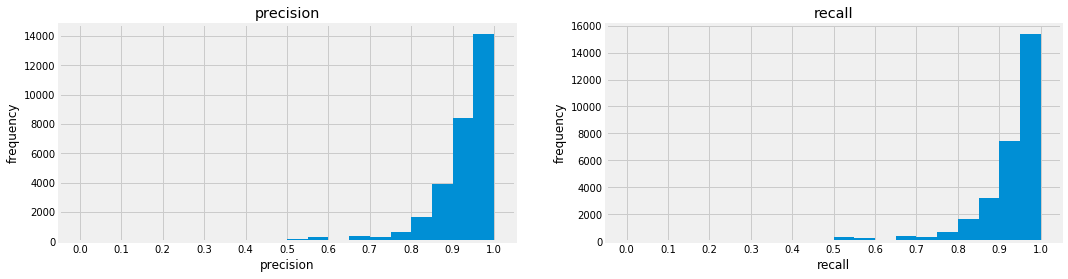

In [14]:
results, a, b, c = run(split_words, testing_text, corpus)

average precision: 0.9303842915060833
average recall 0.9269259636077932
average F1-score 0.9277040668672729


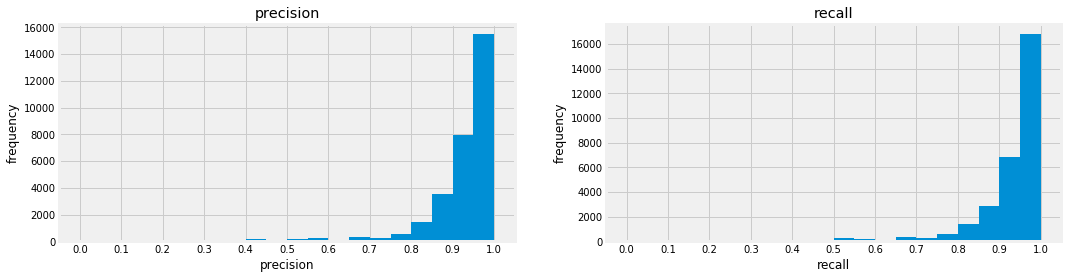

In [19]:
results, a, b, c = run(split_words_reverse, testing_text, corpus)